In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


In [41]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

import xgboost            as xgb
import featuretools       as ft
import seaborn            as sns
import matplotlib.pyplot  as plt
import missingno          as msno
from termcolor import colored

from sklearn.model_selection import train_test_split
from sklearn.neural_network  import MLPClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import classification_report
from sklearn.metrics         import roc_auc_score
from sklearn.preprocessing   import LabelEncoder
from sklearn.impute          import SimpleImputer
from woodwork.logical_types  import Categorical, PostalCode
from imblearn.over_sampling  import SMOTE, ADASYN

# 1. import data 

<div id = 3 style="color:white;    
           display:fill;
           border-radius:5px;
           background-color:#FFC81E;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
           justify-content:center;
           border-width: 0.2rem;
           border-style: solid;
           border-color: #7A86B6">

<h2 style="padding: 2rem;
           color:darkblue;
           text-align:center;
           margin:0 auto;">
데이터 불러오기👀
</h2>
</div>

In [42]:
train = pd.read_csv('../input/tabular-playground-series-aug-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-aug-2022/test.csv')
print(train.shape, test.shape)

(26570, 26) (20775, 25)


In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26570 non-null  int64  
 1   product_code    26570 non-null  object 
 2   loading         26320 non-null  float64
 3   attribute_0     26570 non-null  object 
 4   attribute_1     26570 non-null  object 
 5   attribute_2     26570 non-null  int64  
 6   attribute_3     26570 non-null  int64  
 7   measurement_0   26570 non-null  int64  
 8   measurement_1   26570 non-null  int64  
 9   measurement_2   26570 non-null  int64  
 10  measurement_3   26189 non-null  float64
 11  measurement_4   26032 non-null  float64
 12  measurement_5   25894 non-null  float64
 13  measurement_6   25774 non-null  float64
 14  measurement_7   25633 non-null  float64
 15  measurement_8   25522 non-null  float64
 16  measurement_9   25343 non-null  float64
 17  measurement_10  25270 non-null 

In [44]:
train.describe()

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
count,26570.000000,26320.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26189.000000,26032.000000,25894.000000,...,25343.000000,25270.000000,25102.000000,24969.000000,24796.000000,24696.000000,24561.000000,24460.000000,24286.000000,26570.000000
mean,13284.500000,127.826233,6.754046,7.240459,7.415883,8.232518,6.256568,17.791528,11.731988,17.127804,...,11.430725,16.117711,19.172085,11.702464,15.652904,16.048444,14.995554,16.460727,701.269059,0.212608
std,7670.242662,39.030020,1.471852,1.456493,4.116690,4.199401,3.309109,1.001200,0.996085,0.996414,...,0.999137,1.405978,1.520785,1.488838,1.155247,1.491923,1.549226,1.708935,123.304161,0.409160
min,0.000000,33.160000,5.000000,5.000000,0.000000,0.000000,0.000000,13.968000,8.008000,12.073000,...,7.537000,9.323000,12.461000,5.167000,10.890000,9.140000,9.104000,9.701000,196.787000,0.000000
25%,6642.250000,99.987500,6.000000,6.000000,4.000000,5.000000,4.000000,17.117000,11.051000,16.443000,...,10.757000,15.209000,18.170000,10.703000,14.890000,15.057000,13.957000,15.268000,618.961500,0.000000
50%,13284.500000,122.390000,6.000000,8.000000,7.000000,8.000000,6.000000,17.787000,11.733000,17.132000,...,11.430000,16.127000,19.211500,11.717000,15.628500,16.040000,14.969000,16.436000,701.024500,0.000000
75%,19926.750000,149.152500,8.000000,8.000000,10.000000,11.000000,8.000000,18.469000,12.410000,17.805000,...,12.102000,17.025000,20.207000,12.709000,16.374000,17.082000,16.018000,17.628000,784.090250,0.000000
max,26569.000000,385.860000,9.000000,9.000000,29.000000,29.000000,24.000000,21.499000,16.484000,21.425000,...,15.412000,22.479000,25.640000,17.663000,22.713000,22.303000,21.626000,24.094000,1312.794000,1.000000


## Train Data , Test Data Shape

In [45]:
print('TRAIN DATA')
print(colored(f'Number of rows in train data: {train.shape[0]}', 'cyan'))
print(colored(f'Number of columns in train data: {train.shape[1]}\n', 'cyan'))
print("TEST DATA")
print(colored(f'Number of rows in test data: {test.shape[0]}', 'green'))
print(colored(f'Number of columns in test data: {test.shape[1]}', 'green'))

TRAIN DATA
Number of rows in train data: 26570
Number of columns in train data: 26

TEST DATA
Number of rows in test data: 20775
Number of columns in test data: 25


<AxesSubplot:xlabel='failure', ylabel='count'>

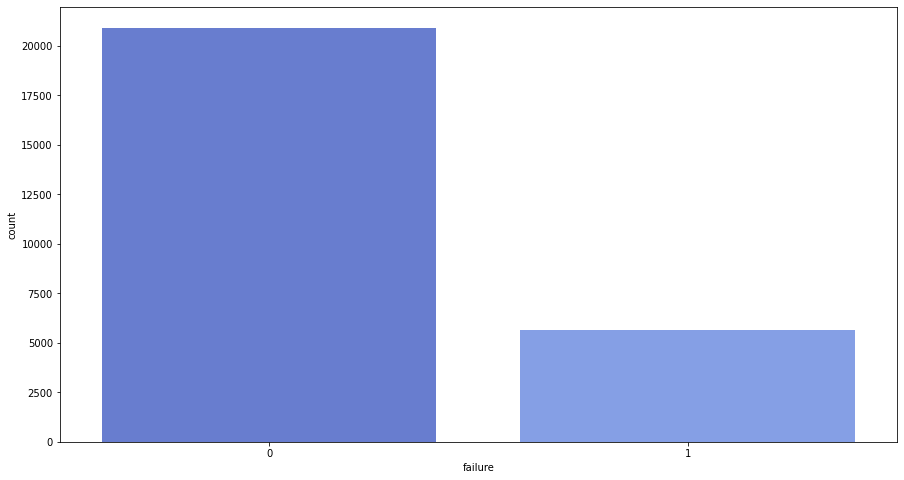

In [46]:
palette3 = sns.color_palette('coolwarm',10)
plt.figure(figsize = (15,8))
sns.countplot(x ='failure',data=train, palette = palette3)

### Missing values

In [25]:
display(train.isna().sum())
print('----------------------')
display(test.isna().sum())

id                   0
product_code         0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
failure              0
dtype: int64

----------------------


id                   0
product_code         0
loading            223
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      329
measurement_4      409
measurement_5      508
measurement_6      624
measurement_7      720
measurement_8      846
measurement_9      904
measurement_10    1067
measurement_11    1136
measurement_12    1240
measurement_13    1303
measurement_14    1440
measurement_15    1542
measurement_16    1678
measurement_17    1740
dtype: int64

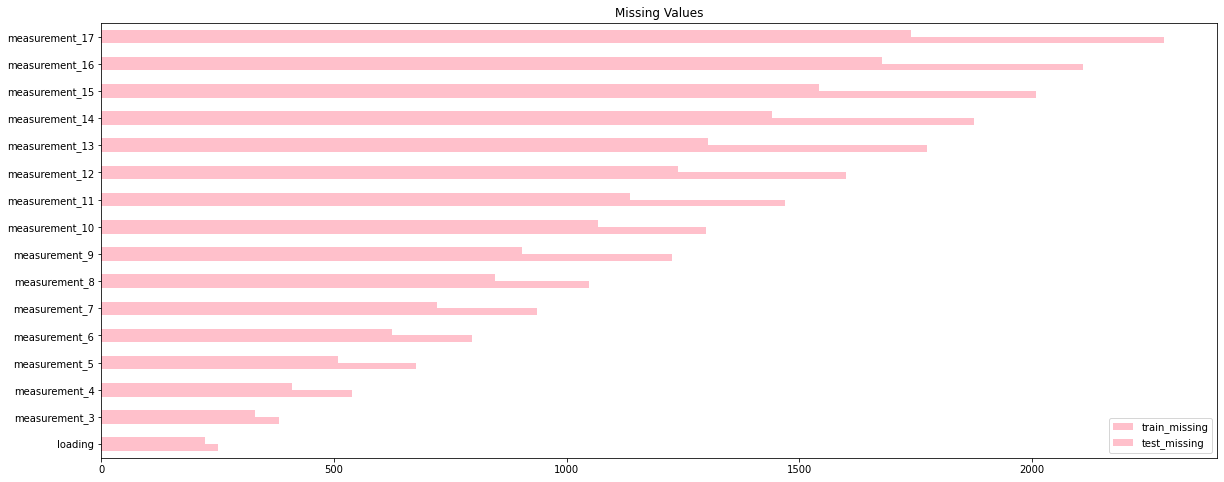

In [26]:
#train / test 결측치 
ncounts = pd.DataFrame([train.isna().sum(), test.isna().sum()]).T
ncounts = ncounts.rename(columns={0: "train_missing", 1: "test_missing"})

ncounts.query("train_missing > 0").plot(
    kind="barh", figsize=(20, 8), title="Missing Values", color = 'pink'
)
plt.show()


In [27]:
from termcolor import colored

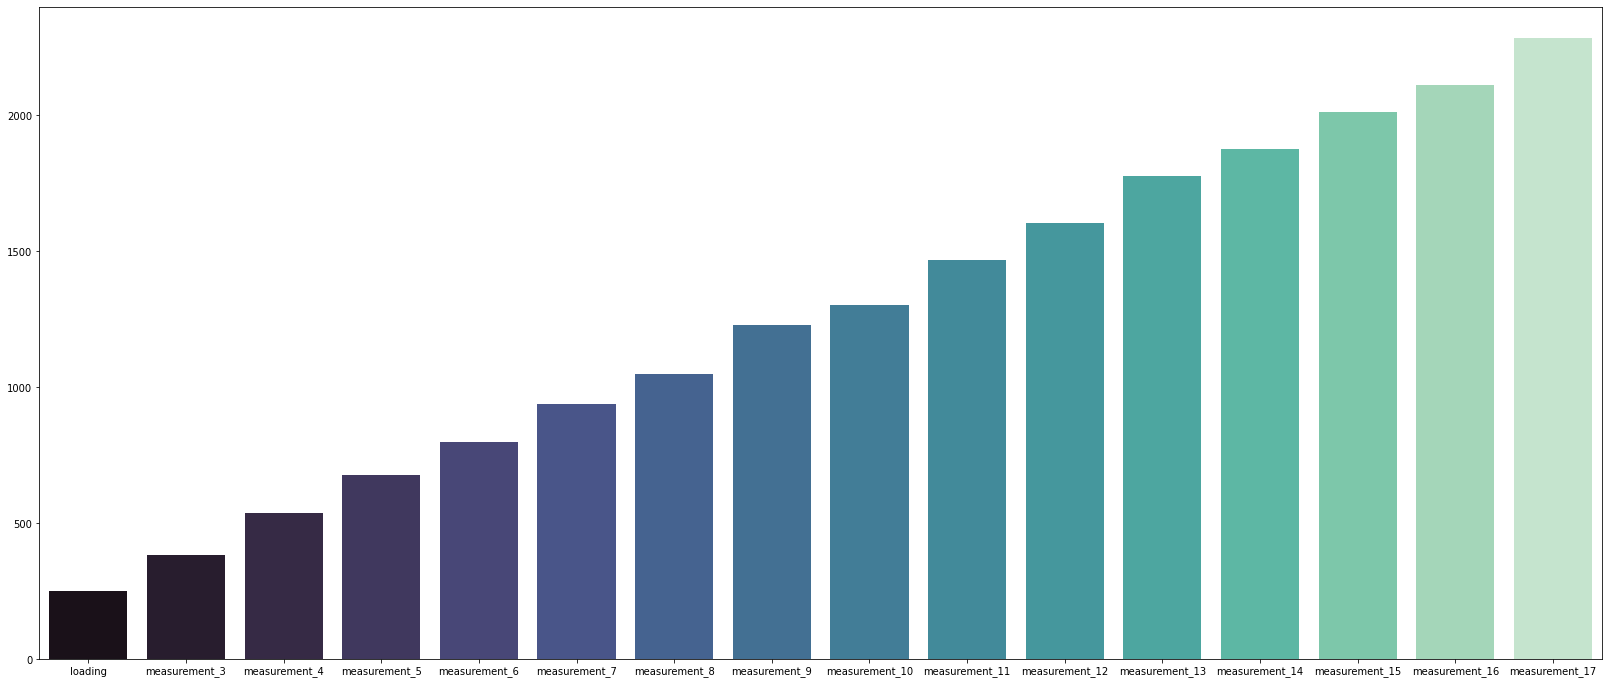

MISSING VALUES IN THE TRAINING SET
loading            250
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
dtype: int64


In [28]:
nan_cols = train.columns[train.isna().any()].tolist()
plt.figure(figsize=(28,12))
nan_count_cols = train[nan_cols].isna().sum()
sns.barplot(y=nan_count_cols, x=nan_cols, palette='mako')
plt.show()
print(colored(f'MISSING VALUES IN THE TRAINING SET', 'cyan', attrs=['bold', 'underline']))
print(colored(nan_count_cols, "green"))

### 상관관계 분석

<AxesSubplot:>

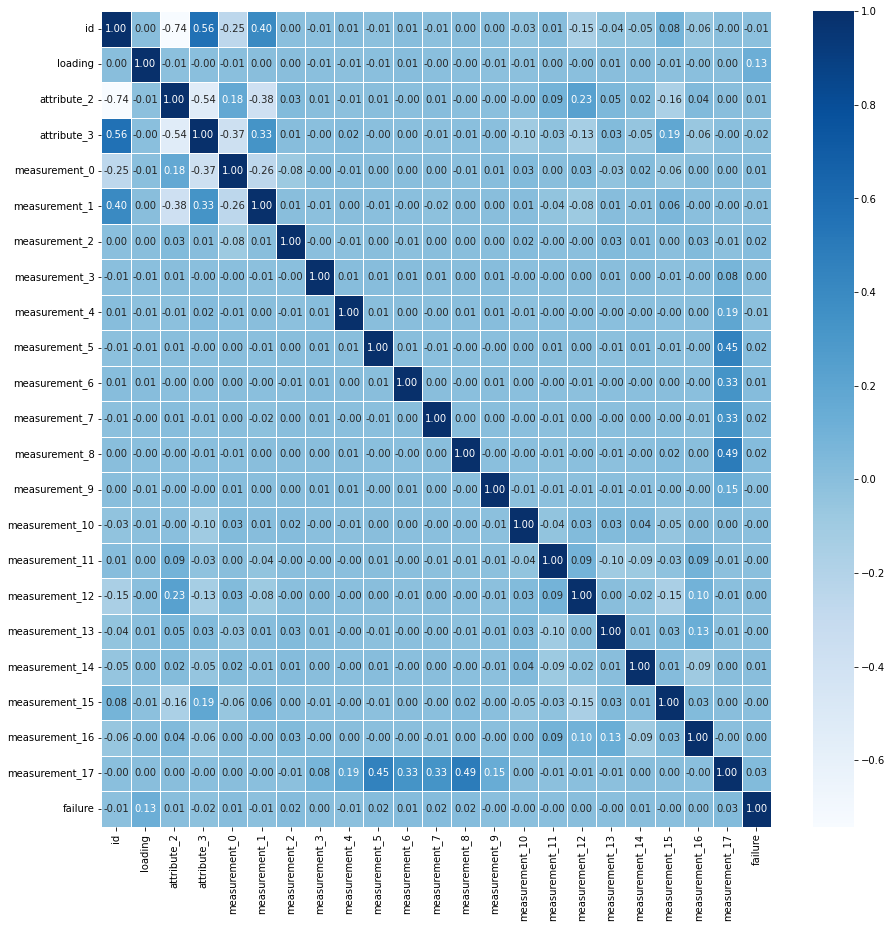

In [29]:
train.corr()
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

### product code별 failure

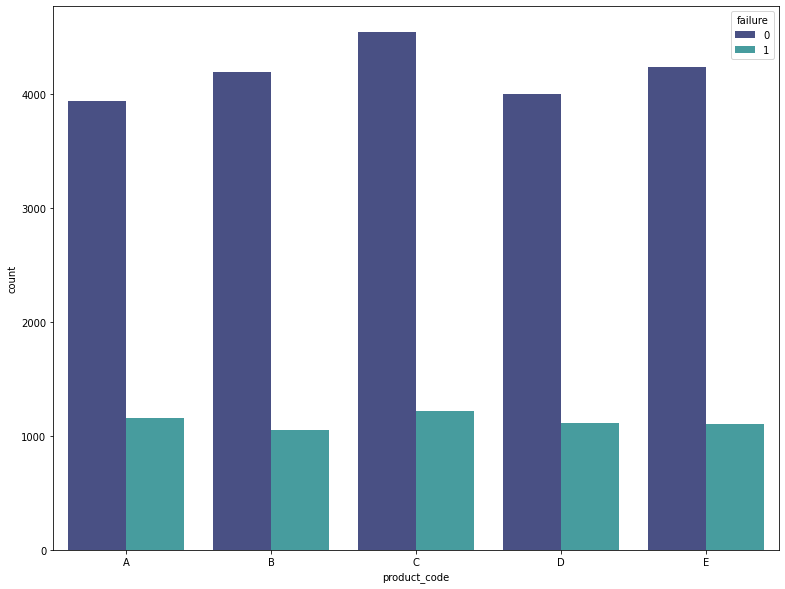

Product codes failure==1/failure==0:

product_code
A    1159/3941, 0.29408779497589443
B    1052/4198, 0.25059552167698906
C     1220/4545, 0.2684268426842684
D                  1112/4000, 0.278
E     1106/4237, 0.2610337502950201
dtype: object


In [40]:
plt.figure(figsize=(13,10))
sns.countplot(x='product_code', hue='failure', data=train, palette='mako')
plt.show()


def cal_ratio_str(x):
    out = []
    n_1 = sum(x['failure'].values == 1)
    n_0 = sum(x['failure'].values == 0)
    ratio = n_1/n_0
    out.append((x.product_code.unique()[0], ratio))
    return '{:}/{:}, {:}'.format(n_1, n_0, ratio)

def cal_ratio_list(x):
    out = []
    n_1 = sum(x['failure'].values == 1)
    n_0 = sum(x['failure'].values == 0)
    ratio = n_1/n_0
    out.append((x.product_code.unique()[0], ratio))
    return out

str_output = train.groupby('product_code').apply(cal_ratio_str)
product_code_ratios = train.groupby('product_code').apply(cal_ratio_list)
print(colored(f'Product codes failure==1/failure==0:\n', 'cyan', attrs=['bold', 'underline']))
print(str_output)

In [17]:
y=train["failure"]
train = train.drop(columns=["id","failure"])
test = test.drop(columns="id")

size = train.shape[0]
data = pd.concat((train,test))

# One-Hot Encoding
data=pd.get_dummies(data)

train = data[:size]
test = data[size:]
index = train.columns

In [ ]:
train_A=train[train["product_code_A"]==1]
train_B=train[train["product_code_B"]==1]
train_C=train[train["product_code_C"]==1]
train_D=train[train["product_code_D"]==1]
train_E=train[train["product_code_E"]==1]

test_F=test[test["product_code_F"]==1]
test_G=test[test["product_code_G"]==1]
test_H=test[test["product_code_H"]==1]
test_I=test[test["product_code_I"]==1]

In [ ]:
from sklearn.impute import KNNImputer

# KNN Imputer
imputer = KNNImputer(n_neighbors=5)

train_A=pd.DataFrame(data=imputer.fit_transform(train_A),columns=index)
train_B=pd.DataFrame(data=imputer.fit_transform(train_B),columns=index)
train_C=pd.DataFrame(data=imputer.fit_transform(train_C),columns=index)
train_D=pd.DataFrame(data=imputer.fit_transform(train_D),columns=index)
train_E=pd.DataFrame(data=imputer.fit_transform(train_E),columns=index)

test_F=pd.DataFrame(data=imputer.fit_transform(test_F),columns=index)
test_G=pd.DataFrame(data=imputer.fit_transform(test_G),columns=index)
test_H=pd.DataFrame(data=imputer.fit_transform(test_H),columns=index)
test_I=pd.DataFrame(data=imputer.fit_transform(test_I),columns=index)

train=pd.concat((train_A,train_B,train_C,train_D,train_E))
test=pd.concat((test_F,test_G,test_H,test_I))

In [ ]:
!git clone https://github.com/analokmaus/kuma_utils.git
import sys; sys.path.append("kuma_utils/")
from kuma_utils.preprocessing.imputer import LGBMImputer

In [ ]:
imputer = LGBMImputer(n_iter=100)

train_A=pd.DataFrame(data=imputer.fit_transform(train_A),columns=index)
train_B=pd.DataFrame(data=imputer.fit_transform(train_B),columns=index)
train_C=pd.DataFrame(data=imputer.fit_transform(train_C),columns=index)
train_D=pd.DataFrame(data=imputer.fit_transform(train_D),columns=index)
train_E=pd.DataFrame(data=imputer.fit_transform(train_E),columns=index)

test_F=pd.DataFrame(data=imputer.fit_transform(test_F),columns=index)
test_G=pd.DataFrame(data=imputer.fit_transform(test_G),columns=index)
test_H=pd.DataFrame(data=imputer.fit_transform(test_H),columns=index)
test_I=pd.DataFrame(data=imputer.fit_transform(test_I),columns=index)

train=pd.concat((train_A,train_B,train_C,train_D,train_E))
test=pd.concat((test_F,test_G,test_H,test_I))

In [ ]:
column_name=["product_code_A","product_code_B","product_code_C","product_code_D","product_code_E","product_code_F","product_code_G","product_code_H","product_code_I",
        "attribute_0_material_5","attribute_0_material_7","attribute_1_material_5","attribute_1_material_6","attribute_1_material_7","attribute_1_material_8"]
train=train.drop(columns=column_name)
test=test.drop(columns=column_name)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

rcf = RandomForestClassifier()
scores = cross_val_score(rcf, train, y,
                        scoring='accuracy', cv=3)
print('원본 데이터셋 - 각 Fold별 정확도 :', scores)
print('원본 데이터셋 - 평균 정확도 :', np.mean(scores))

# Scaling 적용
scaler = StandardScaler()
df_scaled = scaler.fit_transform(train)

# PCA
for i in range(1,20):
    pca = PCA(n_components=i)
    df_pca = pca.fit_transform(df_scaled)
    scores_pca = cross_val_score(rcf, df_pca, y,
                                scoring='accuracy', cv=3)
    print('PCA적용 후 데이터셋 - 각 Fold별 정확도 :', np.mean(scores_pca))
    print('PCA적용 후 데이터셋 - 평균 정확도 :', np.mean(scores))

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)

train = pca.fit_transform(train)
test = pca.transform(test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [ ]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [ ]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(12, 12), facecolor='#EAECEE')
cmap = sns.color_palette("pastel", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1., center=0, annot=False,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.75})

ax.set_title('Correlation heatmap', fontsize=24, y= 1.05)
colorbar = ax.collections[0].colorbar

In [ ]:
! pip install --ignore-installed --pre pycaret

In [ ]:
from pycaret.classification import setup, compare_models, blend_models, finalize_model, predict_model, get_config

In [ ]:
def pycaret_model(train, target,test, n_select, fold,opt):
    print('Setup Your Data....')
    setup(data=train,
          target=target)
  
    print('Comparing Models....')
    best = compare_models(sort = opt,n_select=n_select, fold = fold)
    
    print('Blending Models....')
    blended = blend_models(estimator_list= best, fold=fold, optimize=opt)

    prep_pipe = get_config("pipeline")
    prep_pipe.steps.append(['final_model', blended])
    pred = prep_pipe.predict_proba(test)[:,1]
    
    return pred

In [ ]:
result = pycaret_model(train,y,test, 3, 5, 'AUC')

In [ ]:
submission = pd.read_csv('../input/tabular-playground-series-aug-2022/sample_submission.csv')
submission

In [ ]:
submission["failure"] = result
submission["failure"].value_counts()

In [ ]:
submission

In [ ]:
version_x = input()
submission.to_csv(f"./submission_{version_x}.csv", index=False)